In [13]:
import sys
sys.path.append("../underactuated")

import numpy as np

from sos_swingup import *
from polynomial_fvi import pendulum_setup
from pydrake.examples.pendulum import (PendulumPlant)
from pydrake.all import (DiagramBuilder, Simulator, WrapToSystem, LeafSystem,
                         BasicVector)
from underactuated.pendulum import PendulumVisualizer
from underactuated.jupyter import AdvanceToAndVisualize

In [14]:
class Controller(LeafSystem):
    def __init__(self, u_star, z, plant, params_dict):
        LeafSystem.__init__(self)
        self.plant = plant
        self.context = plant.CreateDefaultContext()
        self.x_dim = 2
        self.u_dim = 1
        self.x2z = params_dict["x2z"]
        self.u_star = u_star
        self.z = z

        self.state_input_port = self.DeclareVectorInputPort(
            "state", BasicVector(self.x_dim))

        self.policy_output_port = self.DeclareVectorOutputPort(
            "policy", BasicVector(self.u_dim), self.CalculateController)

    def CalculateController(self, context, output):
        state = self.state_input_port.Eval(context)
        state[0] = state[0] + np.pi
        z_value = self.x2z(state)
        y = output.get_mutable_value()
        y[:]  = u_star[0].Evaluate({z[0]: z_value[0], z[1]: z_value[1], z[2]: z_value[2]})


In [15]:
def simulate(u_star, z, params_dict):
    # Animate the resulting policy.
    builder = DiagramBuilder()
    pendulum = builder.AddSystem(PendulumPlant())

    wrap = builder.AddSystem(WrapToSystem(2))
    wrap.set_interval(0, 0, 2*np.pi)
    builder.Connect(pendulum.get_output_port(0), wrap.get_input_port(0))
    vi_policy = Controller(u_star, z, pendulum, params_dict)
    builder.AddSystem(vi_policy)
    builder.Connect(wrap.get_output_port(0), vi_policy.get_input_port(0))
    builder.Connect(vi_policy.get_output_port(0),
                    pendulum.get_input_port(0))

    visualizer = builder.AddSystem(
        PendulumVisualizer(show=False))
    builder.Connect(pendulum.get_output_port(0),
                    visualizer.get_input_port(0))

    diagram = builder.Build()
    simulator = Simulator(diagram)
    simulator.get_mutable_context().SetContinuousState([0.1, 0.0])

    AdvanceToAndVisualize(simulator, visualizer, 10.)

simulating...  done.
generating animation...


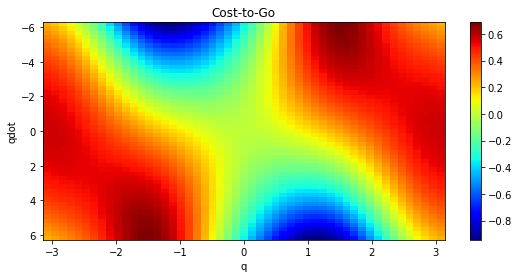

In [16]:
J_star, u_star, z = pendulum_sos_dp(deg=4)
params_dict = pendulum_setup("monomial")
simulate(u_star, z, params_dict)